In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
from matplotlib import rc

In [3]:
df = pd.read_csv("../data/clean_data.csv", sep=",", index_col=0)
df.head()

,id,title,area,interpretability,doi,source,working_doi,abstract,embedding,classifier_interpretability_prediction
0,main.8,Large Scale Multi-Actor Generative Dialog Mode...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.8,ACL2020,True,Non-goal oriented dialog agents (i.e. chatbots...,[-5.58118939e-01 -1.25368834e-01 -6.33979887e-...,False
1,main.52,CDL: Curriculum Dual Learning for Emotion-Cont...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.52,ACL2020,True,Emotion-controllable response generation is an...,[-1.12784958e+00 -5.22979379e-01 5.63119724e-...,False
2,main.46,Emergence of Syntax Needs Minimal Supervision,Theory and Formalism in NLP (Linguistic and Ma...,False,10.18653/v1/2020.acl-main.46,ACL2020,True,This paper is a theoretical contribution to th...,[ 2.61768043e-01 8.10616314e-01 2.74266422e-...,False
3,main.359,Selecting Backtranslated Data from Multiple So...,Machine Translation,False,10.18653/v1/2020.acl-main.359,ACL2020,True,Machine translation (MT) has benefited from us...,[-4.39277172e-01 1.06740630e+00 8.58952925e-...,False
4,main.417,ParaCrawl: Web-Scale Acquisition of Parallel C...,Resources and Evaluation,False,10.18653/v1/2020.acl-main.417,ACL2020,True,We report on methods to create the largest pub...,[-3.59388590e-01 3.36527884e-01 -2.65376344e-...,False


In [4]:
df.loc[:, 'year'] = df['source'].apply(lambda x: int(x[-4:]))

df                                            

,id,title,area,interpretability,doi,source,working_doi,abstract,embedding,classifier_interpretability_prediction,year
0,main.8,Large Scale Multi-Actor Generative Dialog Mode...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.8,ACL2020,True,Non-goal oriented dialog agents (i.e. chatbots...,[-5.58118939e-01 -1.25368834e-01 -6.33979887e-...,False,2020
1,main.52,CDL: Curriculum Dual Learning for Emotion-Cont...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.52,ACL2020,True,Emotion-controllable response generation is an...,[-1.12784958e+00 -5.22979379e-01 5.63119724e-...,False,2020
2,main.46,Emergence of Syntax Needs Minimal Supervision,Theory and Formalism in NLP (Linguistic and Ma...,False,10.18653/v1/2020.acl-main.46,ACL2020,True,This paper is a theoretical contribution to th...,[ 2.61768043e-01 8.10616314e-01 2.74266422e-...,False,2020
3,main.359,Selecting Backtranslated Data from Multiple So...,Machine Translation,False,10.18653/v1/2020.acl-main.359,ACL2020,True,Machine translation (MT) has benefited from us...,[-4.39277172e-01 1.06740630e+00 8.58952925e-...,False,2020
4,main.417,ParaCrawl: Web-Scale Acquisition of Parallel C...,Resources and Evaluation,False,10.18653/v1/2020.acl-main.417,ACL2020,True,We report on methods to create the largest pub...,[-3.59388590e-01 3.36527884e-01 -2.65376344e-...,False,2020
...,...,...,...,...,...,...,...,...,...,...,...
9277,889,Multimodal Transformer for Unaligned Multimoda...,"Vision, Robotics, Multimodal, Grounding and Sp...",NaN,10.18653/v1/P19-1656,ACL2019,True,"Human language is often multimodal, which comp...",[-2.53148854e-01 -8.23063105e-02 -3.35774094e-...,False,2019
9278,2155,"Show, Describe and Conclude: On Exploiting the...","Vision, Robotics, Multimodal, Grounding and Sp...",NaN,10.18653/v1/P19-1657,ACL2019,True,Chest X-Ray (CXR) images are commonly used for...,[-4.88766015e-01 -3.07189375e-01 -1.30685127e+...,False,2019
9279,384,Visual Story Post-Editing,"Vision, Robotics, Multimodal, Grounding and Sp...",NaN,10.18653/v1/P19-1658,ACL2019,True,We introduce the first dataset for human edits...,[-6.34846449e-01 -2.18937039e-01 9.53872725e-...,False,2019
9280,1891,Multimodal Abstractive Summarization for How2 ...,"Vision, Robotics, Multimodal, Grounding and Sp...",NaN,10.18653/v1/P19-1659,ACL2019,True,"In this paper, we study abstractive summarizat...",[-9.39114809e-01 -1.15553305e-01 -6.91273287e-...,False,2019


In [5]:
filter_2020 = df['source'].str.endswith('2020')
filter_2021 = df['source'].str.endswith('2021')
filter_2022 = df['source'].str.endswith('2022')
filter_2023 = df['source'].str.endswith('2023')
combined_filter = filter_2020 | filter_2021 | filter_2022 | filter_2023

post_2020_df = df[combined_filter].copy()
post_2020_df.head()

,id,title,area,interpretability,doi,source,working_doi,abstract,embedding,classifier_interpretability_prediction,year
0,main.8,Large Scale Multi-Actor Generative Dialog Mode...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.8,ACL2020,True,Non-goal oriented dialog agents (i.e. chatbots...,[-5.58118939e-01 -1.25368834e-01 -6.33979887e-...,False,2020
1,main.52,CDL: Curriculum Dual Learning for Emotion-Cont...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.52,ACL2020,True,Emotion-controllable response generation is an...,[-1.12784958e+00 -5.22979379e-01 5.63119724e-...,False,2020
2,main.46,Emergence of Syntax Needs Minimal Supervision,Theory and Formalism in NLP (Linguistic and Ma...,False,10.18653/v1/2020.acl-main.46,ACL2020,True,This paper is a theoretical contribution to th...,[ 2.61768043e-01 8.10616314e-01 2.74266422e-...,False,2020
3,main.359,Selecting Backtranslated Data from Multiple So...,Machine Translation,False,10.18653/v1/2020.acl-main.359,ACL2020,True,Machine translation (MT) has benefited from us...,[-4.39277172e-01 1.06740630e+00 8.58952925e-...,False,2020
4,main.417,ParaCrawl: Web-Scale Acquisition of Parallel C...,Resources and Evaluation,False,10.18653/v1/2020.acl-main.417,ACL2020,True,We report on methods to create the largest pub...,[-3.59388590e-01 3.36527884e-01 -2.65376344e-...,False,2020


In [6]:
# it is not clear whether these papers are from interpretability, as the track is
# "Language Modeling and Analysis of Language Models" and also
# they mixed areas in some of the time blocks where some papers were presented.
# these were not used to train the classifier, but in this code they will
# be considered from interpretability

set(post_2020_df[post_2020_df['interpretability'].isna()]['area'])

{'Interpretability and Analysis of Models for NLP; Language Generation',
 'Interpretability and Analysis of Models for NLP; Summarization',
 'Language Modeling and Analysis of Language Models'}

In [7]:
raw_tracks = set(post_2020_df['area'])

raw_tracks

{'Cognitive Modeling and Psycholinguistics',
 'Commonsense Reasoning',
 'Computational Social Science and Cultural Analytics',
 'Computational Social Science and Social Media',
 'Computational Social Science and Social Media; Language Generation',
 'Computational Social Science and Social Media; NLP Applications',
 'Computational Social Science and Social Media; Sentiment Analysis, Stylistic Analysis, and Argument Mining',
 'Demos',
 'Dialog and Interactive Systems',
 'Dialog and Interactive Systems; Discourse and Pragmatics',
 'Dialog and Interactive Systems; Linguistic Theories, Cognitive Modeling and Psycholinguistics',
 'Dialogue and Interactive Systems',
 'Discourse and Pragmatics',
 'Discourse and Pragmatics & Ethics in NLP',
 'Discourse and Pragmatics; Language Generation',
 'Discourse and Pragmatics; Machine Translation and Multilinguality',
 'Efficient Methods for NLP',
 'Ethic Concerns:Dialogue and Interactive Systems',
 'Ethic Concerns:Ethics',
 'Ethic Concerns:Linguistic Th

In [8]:
analysis_or_interpretability_tracks = list(filter(lambda x: 'interpretability' in x.lower() or 'analysis of language models' in x.lower(), raw_tracks))
print('interp & analysis tracks')
print(analysis_or_interpretability_tracks)
print()

syntax_tracks = list(filter(lambda x: 'syntax' in x.lower(), raw_tracks))
print('syntax tracks')
print(syntax_tracks)
print()

mt_tracks = list(filter(lambda x: 'translation' in x.lower(), raw_tracks))
print('MT tracks')
print(mt_tracks)
print()

grounding_tracks = list(filter(lambda x: 'grounding' in x.lower(), raw_tracks))
print('grounding tracks')
print(grounding_tracks)
print()

semantics_tracks = list(filter(lambda x: 'semantics' in x.lower(), raw_tracks))
print('semantics tracks')
print(semantics_tracks)
print()

evaluation_tracks = list(filter(lambda x: 'evaluation' in x.lower(), raw_tracks))
print('evaluation tracks')
print(evaluation_tracks)
print()

info_extraction_tracks = list(filter(lambda x: 'extraction' in x.lower(), raw_tracks))
print('info_extraction tracks')
print(info_extraction_tracks)
print()

qa_tracks = list(filter(lambda x: 'answering' in x.lower(), raw_tracks))
print('qa_tracks')
print(qa_tracks)
print()

dialogue_tracks = list(filter(lambda x: 'dialog' in x.lower(), raw_tracks))
print('dialogue_tracks')
print(dialogue_tracks)
print()

sentiment_analysis_tracks = list(filter(lambda x: 'sentiment analysis' in x.lower(), raw_tracks))
print('sentiment_analysis_tracks')
print(sentiment_analysis_tracks)
print()

interp & analysis tracks
['Language Modeling and Analysis of Language Models', 'Interpretability and Analysis of Models for NLP; Language Generation', 'Interpretability and Analysis of Models for NLP', 'Interpretability and Analysis of Models for NLP; Summarization', 'Interpretability, Interactivity and Analysis of Models for NLP', 'Interpretability, Interactivity, and Analysis of Models for NLP']

syntax tracks
['Syntax: Tagging, Chunking and Parsing', 'Syntax, Parsing and their Applications', 'Syntax: Tagging, Chunking, and Parsing']

MT tracks
['Discourse and Pragmatics; Machine Translation and Multilinguality', 'Machine Translation', 'Machine Translation and Multilinguality', 'Machine Translation and Multilinguality; Phonology, Morphology and Word Segmentation']

grounding tracks
['Ethic Concerns:Speech, Vision, Robotics, Multimodal Grounding', 'Language Grounding to Vision, Robotics and Beyond; Question Answering', 'Speech, Vision, Robotics, Multimodal Grounding', 'Language Ground

In [9]:
def raw_track_to_track(raw_track):
    if raw_track in analysis_or_interpretability_tracks:
        return 'Interpretability and Analysis'
    if raw_track in syntax_tracks:
        return 'Syntax'
    if raw_track in mt_tracks:
        return 'Machine Translation'
    if raw_track in grounding_tracks:
        return 'Grounding'
    if raw_track in semantics_tracks:
        return 'Semantics'
    if raw_track in evaluation_tracks:
        return 'Evaluation'
    if raw_track in info_extraction_tracks:
        return 'Information Extraction'
    if raw_track in qa_tracks:
        return 'Question Answering'
    if raw_track in dialogue_tracks:
        return 'Dialogue'
    if raw_track in sentiment_analysis_tracks:
        return 'Dialogue'
    return None


post_2020_df['track'] = post_2020_df['area'].apply(raw_track_to_track)
post_2020_df

,id,title,area,interpretability,doi,source,working_doi,abstract,embedding,classifier_interpretability_prediction,year,track
0,main.8,Large Scale Multi-Actor Generative Dialog Mode...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.8,ACL2020,True,Non-goal oriented dialog agents (i.e. chatbots...,[-5.58118939e-01 -1.25368834e-01 -6.33979887e-...,False,2020,Dialogue
1,main.52,CDL: Curriculum Dual Learning for Emotion-Cont...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.52,ACL2020,True,Emotion-controllable response generation is an...,[-1.12784958e+00 -5.22979379e-01 5.63119724e-...,False,2020,Dialogue
2,main.46,Emergence of Syntax Needs Minimal Supervision,Theory and Formalism in NLP (Linguistic and Ma...,False,10.18653/v1/2020.acl-main.46,ACL2020,True,This paper is a theoretical contribution to th...,[ 2.61768043e-01 8.10616314e-01 2.74266422e-...,False,2020,None
3,main.359,Selecting Backtranslated Data from Multiple So...,Machine Translation,False,10.18653/v1/2020.acl-main.359,ACL2020,True,Machine translation (MT) has benefited from us...,[-4.39277172e-01 1.06740630e+00 8.58952925e-...,False,2020,Machine Translation
4,main.417,ParaCrawl: Web-Scale Acquisition of Parallel C...,Resources and Evaluation,False,10.18653/v1/2020.acl-main.417,ACL2020,True,We report on methods to create the largest pub...,[-3.59388590e-01 3.36527884e-01 -2.65376344e-...,False,2020,Evaluation
...,...,...,...,...,...,...,...,...,...,...,...,...
8196,4608,PAR: Political Actor Representation Learning w...,NLP Applications,False,b4c9b57c0d9aacfa98db6247015def1826172bbd,EMNLP2022,True,Modeling the ideological perspectives of polit...,[-1.05176818e+00 1.95948914e-01 -1.77151358e+...,False,2022,None
8197,4613,JDDC 2.1: A Multimodal Chinese Dialogue Datase...,Resources and Evaluation,False,10.18653/v1/2022.emnlp-main.825,EMNLP2022,True,The popularity of multimodal dialogue has stim...,[-1.61390126e+00 -7.88330853e-01 -3.42035651e-...,False,2022,Evaluation
8198,4618,PCL: Peer-Contrastive Learning with Diverse Au...,"Semantics: Lexical, Sentence level, Textual In...",False,10.18653/v1/2022.emnlp-main.826,EMNLP2022,True,Learning sentence embeddings in an unsupervise...,[-5.13262928e-01 6.01322949e-03 -2.11887196e-...,False,2022,Semantics
8199,4621,Digging Errors in NMT: Evaluating and Understa...,Machine Translation,False,10.18653/v1/2022.emnlp-main.827,EMNLP2022,True,Solid evaluation of neural machine translation...,[ 3.79095674e-01 -6.00754097e-03 -3.94643515e-...,False,2022,Machine Translation


In [10]:
from matplotlib import colormaps

all_tracks = list(set(post_2020_df['track']))
colors = plt.cm.get_cmap('tab20', len(all_tracks))
color_mapping = {track: colors(i) for i, track in enumerate(all_tracks)}


/var/folders/jd/xcxq41xd1bx5jvgpwp14tr940000gn/T/ipykernel_19487/1670353249.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(all_tracks))


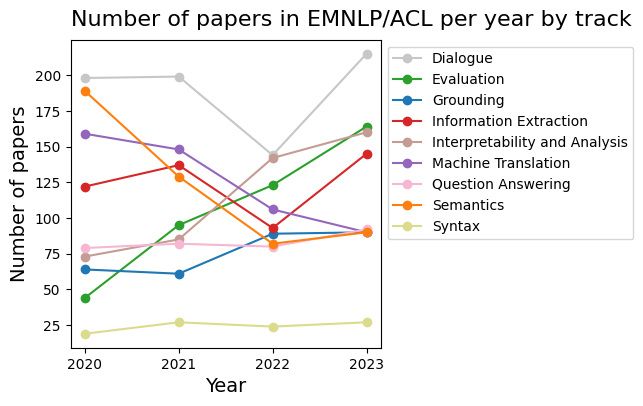

In [11]:
import matplotlib.ticker as ticker

count_data = post_2020_df.groupby('year')['track'].value_counts().unstack().fillna(0)


tracks = count_data.columns
fig, ax = plt.subplots(figsize=(4, 4))
for track in tracks:
    ax.plot(count_data.index, count_data[track], marker='o', color=color_mapping[track], label=track)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of papers', fontsize=14)
plt.title('Number of papers in EMNLP/ACL per year by track', fontsize=16, pad=10, loc='left')
plt.tight_layout
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.show()


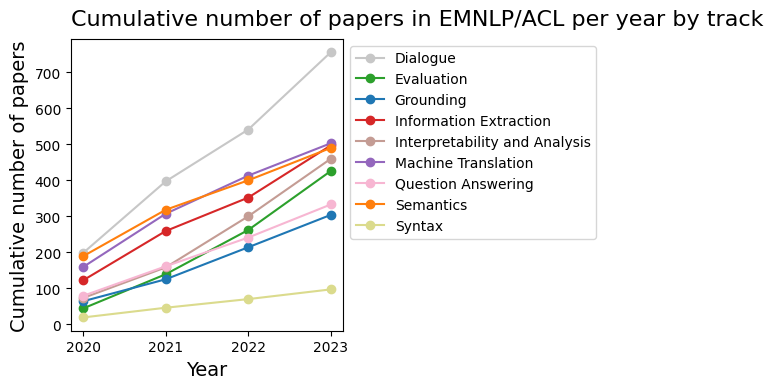

In [12]:
import matplotlib.ticker as ticker

cumulative_data = count_data.cumsum()

tracks = cumulative_data.columns
fig, ax = plt.subplots(figsize=(4, 4))
for track in tracks:
    ax.plot(cumulative_data.index, cumulative_data[track], marker='o', color=color_mapping[track], label=track)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Cumulative number of papers', fontsize=14)
plt.title('Cumulative number of papers in EMNLP/ACL per year by track', fontsize=16, pad=10, loc='left')
plt.tight_layout()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


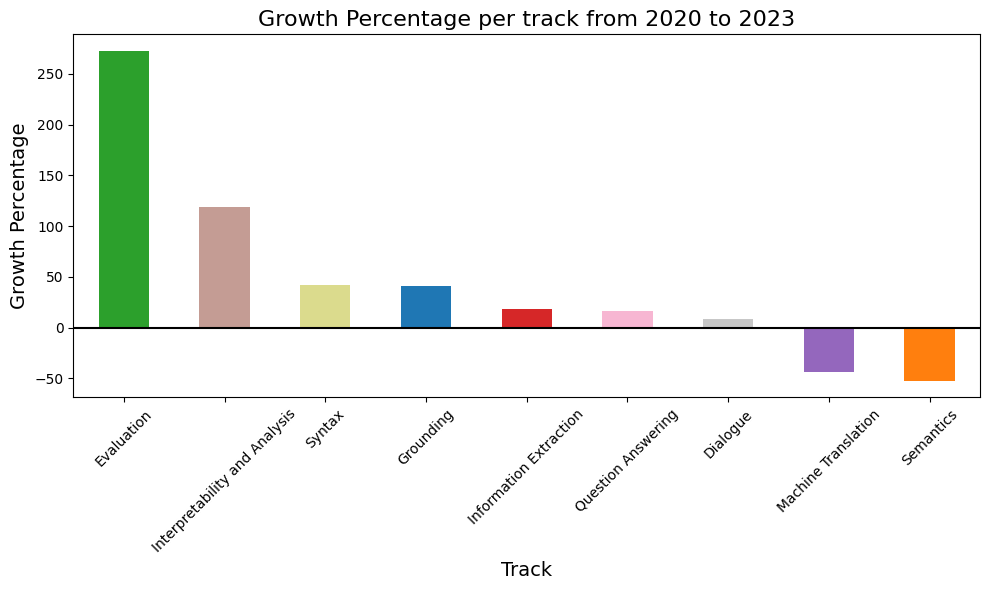

In [13]:
import matplotlib.pyplot as plt

data_2021 = count_data.loc[2020]
data_2023 = count_data.loc[2023]

growth_percentage = ((data_2023 - data_2021) / data_2021) * 100

sorted_growth = growth_percentage.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_growth.plot(kind='bar', color=[color_mapping[track] for track in sorted_growth.index])

plt.xlabel('Track', fontsize=14)
plt.ylabel('Growth Percentage', fontsize=14)
plt.title('Growth Percentage per track from 2020 to 2023', fontsize=16)
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linewidth=1.5)
plt.tight_layout()
plt.savefig('growth_2020_to_2023.png')


# Citation data by track

In [14]:
from utils import bulk_get_paper_details


semantic_scholar_papers = bulk_get_paper_details(list(post_2020_df['doi']))
semantic_scholar_papers

Fetching papers: 15it [00:15,  1.02s/it]


 ...]

In [15]:
# these papers cannot be found in the semantic scholar API,
# so we can gather this info manually from google scholar
doi_to_n_citations = {
    '10.18653/v1/2021.emnlp-main.582': 14,
    '10.48550/arXiv.2306.09802': 2,
    '10.18653/v1/2023.acl-long.835': 6,
    '10.18653/v1/2023.acl-long.725': 10,
    '10.18653/v1/2021.acl-long.148': 62,
    '10.18653/v1/2022.emnlp-main.650': 27,
    '10.18653/v1/2022.emnlp-main.674': 17
}



n_citations = []
for paper, doi in zip(semantic_scholar_papers, list(post_2020_df['doi'])):
    if paper is None:
        n_citations.append(doi_to_n_citations[doi])
    else:
        n_citations.append(paper.citation_count)
        
post_2020_df.loc[:, 'citation_count'] = n_citations

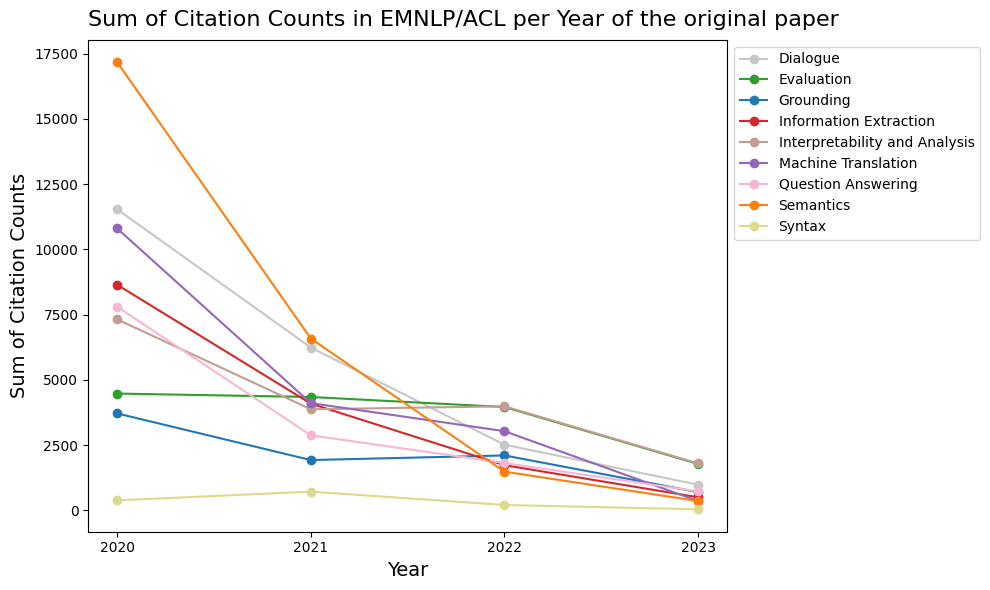

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

summed_data = post_2020_df.groupby(['year', 'track'])['citation_count'].sum().unstack().fillna(0)

tracks = summed_data.columns
fig, ax = plt.subplots(figsize=(10, 6))
for track in tracks:
    ax.plot(summed_data.index, summed_data[track], marker='o', color=color_mapping[track], label=track)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Sum of Citation Counts', fontsize=14)
ax.set_title('Sum of Citation Counts in EMNLP/ACL per Year of the original paper', fontsize=16, pad=10, loc='left')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()


In [17]:
# of course, the older papers are more cited because they have been around longer.
# the interesting thing is that 2023 interpretability papers are the most cited (with evaluation)
# despite not being the track with the most submissions

In [18]:
from utils import get_citation_details

# this works even for 1000+ citations papers
len(get_citation_details('10.18653/v1/2020.acl-main.740'))

1792

In [19]:
tracks = list(set(post_2020_df['track'].dropna()))
years = [2020, 2021, 2022, 2023]

citations_per_year = {track: {year: 0 for year in years} for track in tracks}

In [20]:
from tqdm import tqdm 

for index, row in tqdm(post_2020_df.iterrows(), total=post_2020_df.shape[0]):
    doi = row['doi']
    track = row['track']
    year = row['year']
    if track is None:
        continue
    
    
    citations = get_citation_details(doi)
    for paper in citations:
        citation_paper_year = paper.year

        if citation_paper_year is None or citation_paper_year < 2020:
            # we'll ignore these cases
            continue

        if citation_paper_year > 2023:
            # we'll scope till 2023
            continue
        citations_per_year[track][citation_paper_year] += 1


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 6842/7021 [23:29<00:36,  4.84it/s]

Trying again ... 10.18653/v1/2022.emnlp-main.650
Trying again ... 10.18653/v1/2022.emnlp-main.650
Trying again ... 10.18653/v1/2022.emnlp-main.650
Trying again ... 10.18653/v1/2022.emnlp-main.650
Trying again ... 10.18653/v1/2022.emnlp-main.650
Trying again ... 10.18653/v1/2022.emnlp-main.650
Trying again ... 10.18653/v1/2022.emnlp-main.650
Trying again ... 10.18653/v1/2022.emnlp-main.650
Trying again ... 10.18653/v1/2022.emnlp-main.650
Trying again ... 10.18653/v1/2022.emnlp-main.650


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7021/7021 [24:08<00:00,  4.85it/s]


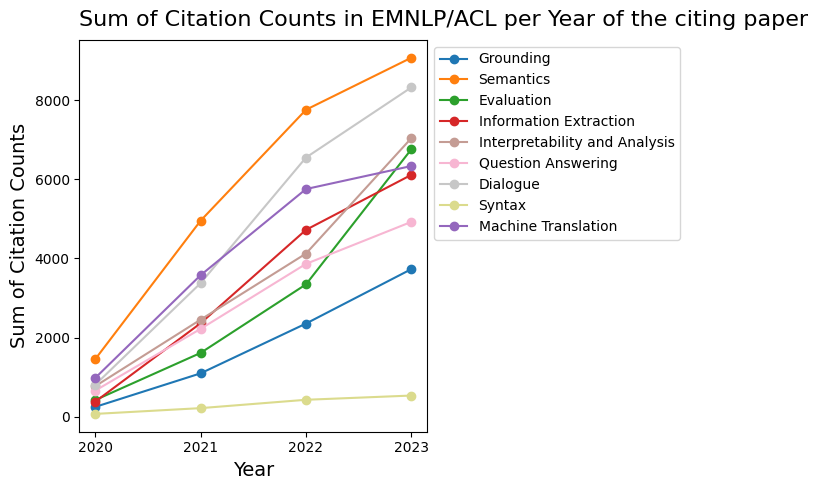

In [21]:
data = pd.DataFrame(citations_per_year, index=years)
fig, ax = plt.subplots(figsize=(7, 5))
for track in data.columns:
    ax.plot(data.index, data[track], marker='o', color=color_mapping[track], label=track)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Sum of Citation Counts', fontsize=14)
ax.set_title('Sum of Citation Counts in EMNLP/ACL per Year of the citing paper', fontsize=16, pad=10, loc='left')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

# Citations comparing analysis/interpretability vs non

In [43]:
# this part requires the graph to be already built
import networkx as nx
import json

with open('../citationgraph/graph.json') as f:
    graph_json = json.load(f)
    G = nx.cytoscape_graph(graph_json)
G.number_of_nodes()

124898

In [44]:
from collections import defaultdict

interp_citation_counts = defaultdict(int)
non_interp_citation_counts = defaultdict(int)

for cited_node, citing_node in G.edges():
    citing_year = G.nodes[citing_node]['year']
    interp = G.nodes[cited_node]['interpretability_boolean']
    if citing_year and 2018 <= citing_year <= 2023:
        if interp:
            interp_citation_counts[citing_year] += 1
        else:
            non_interp_citation_counts[citing_year] += 1

interp_citation_counts, non_interp_citation_counts

(defaultdict(int,
             {2023: 6238,
              2022: 4961,
              2021: 3980,
              2020: 2287,
              2019: 721,
              2018: 131}),
 defaultdict(int,
             {2023: 139786,
              2022: 113488,
              2021: 83743,
              2020: 51953,
              2018: 3119,
              2019: 19611}))

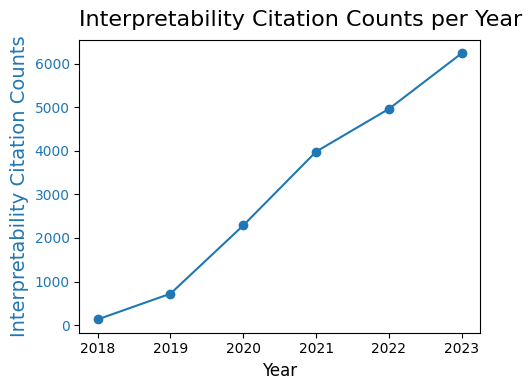

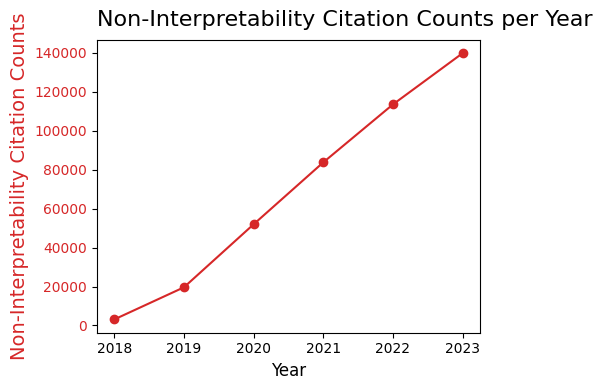

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

years = [2018, 2019, 2020, 2021, 2022, 2023]
data_interp = pd.DataFrame({'Interpretability': [interp_citation_counts.get(year, 0) for year in years]}, index=years)
data_non_interp = pd.DataFrame({'Non-Interpretability': [non_interp_citation_counts.get(year, 0) for year in years]}, index=years)

fig1, ax1 = plt.subplots(figsize=(5, 4))
color = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Interpretability Citation Counts', fontsize=14, color=color)
ax1.plot(data_interp.index, data_interp['Interpretability'], marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Interpretability Citation Counts per Year', fontsize=16, pad=10, loc='left')
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(5, 4))
color = 'tab:red'
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Non-Interpretability Citation Counts', fontsize=14, color=color)
ax2.plot(data_non_interp.index, data_non_interp['Non-Interpretability'], marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Non-Interpretability Citation Counts per Year', fontsize=16, pad=10, loc='left')
plt.tight_layout()
plt.show()

# Which papers are citing interpretability papers?

In [46]:
from collections import defaultdict

interp_citation_counts = defaultdict(int)
non_interp_citation_counts = defaultdict(int)

for cited_node, citing_node in G.edges():
    citing_year = G.nodes[citing_node]['year']
    interp = G.nodes[citing_node]['interpretability_boolean']

    if G.nodes[cited_node]['interpretability_boolean'] is not True:
        continue
    if citing_year and 2018 <= citing_year <= 2023:
        if interp:
            interp_citation_counts[citing_year] += 1
        else:
            non_interp_citation_counts[citing_year] += 1

interp_citation_counts, non_interp_citation_counts

(defaultdict(int,
             {2022: 1312,
              2021: 1130,
              2020: 633,
              2023: 1482,
              2019: 161,
              2018: 29}),
 defaultdict(int,
             {2023: 4756,
              2022: 3649,
              2021: 2850,
              2020: 1654,
              2019: 560,
              2018: 102}))

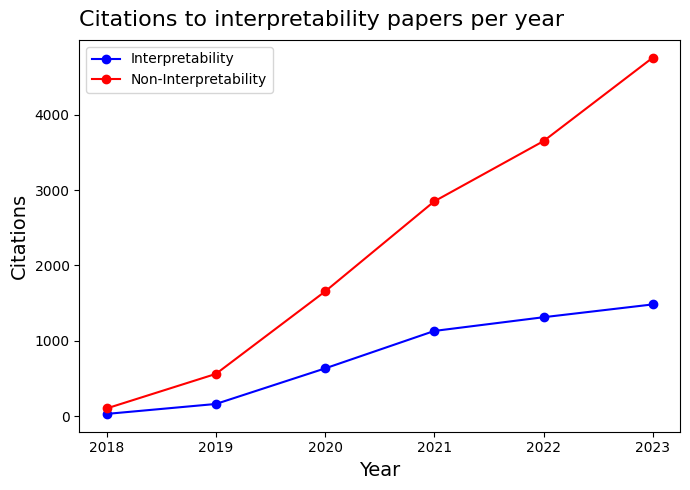

In [47]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Citations', fontsize=14)

years = [2018, 2019, 2020, 2021, 2022, 2023]
data_interp = pd.DataFrame({'Interpretability': [interp_citation_counts.get(year, 0) for year in years]}, index=years)
data_non_interp = pd.DataFrame({'Non-Interpretability': [non_interp_citation_counts.get(year, 0) for year in years]}, index=years)

ax.plot(data_interp.index, data_interp['Interpretability'], marker='o', color='blue', label='Interpretability')
ax.plot(data_non_interp.index, data_non_interp['Non-Interpretability'], marker='o', color='red', label='Non-Interpretability')

ax.tick_params(axis='y')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend()

plt.title('Citations to interpretability papers per year', fontsize=16, pad=10, loc='left')
plt.tight_layout()
plt.show()

# Comparison of citations by track vs survey

WARNING: These results are very noisy, because our areas used in the survey do not align very well to ACL tracks. I do not think we can draw any conlusions from these.

We had these results in the survey.

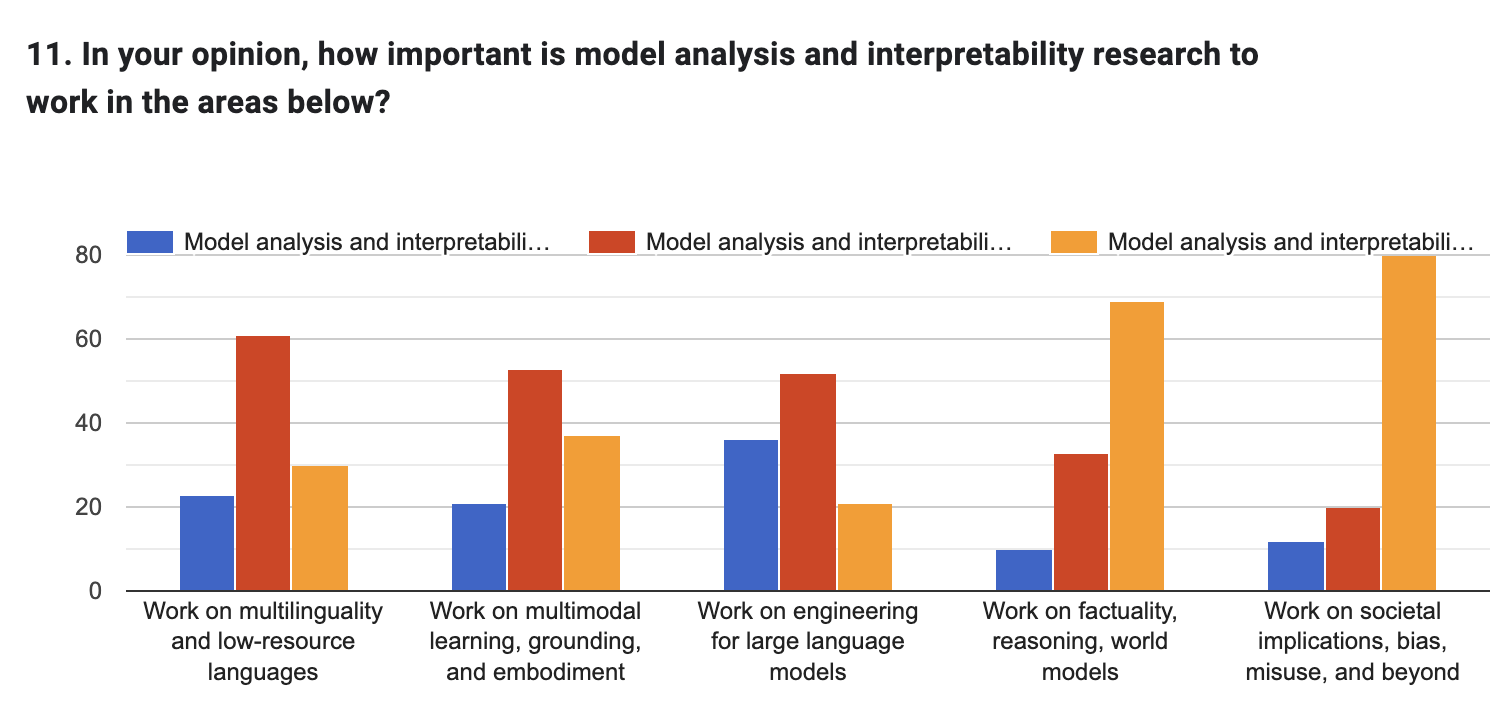

We can contrast this to our citation data.

In [37]:
import pprint

multilinguality = 'Work on multilinguality and low resource'
multimodal = 'Work on multimodal and grounding'
engineering = 'Work on engineering'
factuality = 'Work on factuality and resoning'
bias = 'Work on bias and misuse'

def map_to_survey_area(area):
    if 'bias' in area.lower():
        return bias
    if 'multili' in area.lower():
        return multilinguality
    if 'multimodal' in area.lower():
        return multimodal
    if 'grounding' in area.lower():
        return multimodal
    if 'vision' in area.lower():
        return multimodal
    if 'fact' in area.lower():
        return factuality
    if 'low resour' in area.lower():
        return multilinguality
    if 'efficient' in area.lower():
        return engineering
    if 'reasoning' in area.lower():
        return factuality

    return None

df['survey_area'] = df['area'].map(map_to_survey_area)
print(df['survey_area'].value_counts(dropna=False))
pprint.pp(set(df[pd.isna(df['survey_area'])]['area']))

survey_area
None                                        7935
Work on multimodal and grounding             601
Work on multilinguality and low resource     582
Work on engineering                          113
Work on factuality and resoning               45
Work on bias and misuse                        6
Name: count, dtype: int64
{'Applications',
 'Area A (Information Extraction and Question Answering) [LONG]',
 'Area B (Text Mining and Information Retrieval) [LONG]',
 'Area C (Social Media, Computational Social Science, Sentiment,  Opinion) '
 '[LONG]',
 'Area D (Morphology, Syntax, Chunking, Psycholinguistics) [LONG]',
 'Area E (Semantics) [LONG]',
 'Area H (Machine Learning) [LONG]',
 'Area H or D',
 'Argument Mining',
 'Best Paper Session',
 'Cognitive Modeling and Psycholinguistics',
 'Computational Social Science and Cultural Analytics',
 'Computational Social Science and Social Media',
 'Computational Social Science and Social Media; Language Generation',
 'Computational Social 

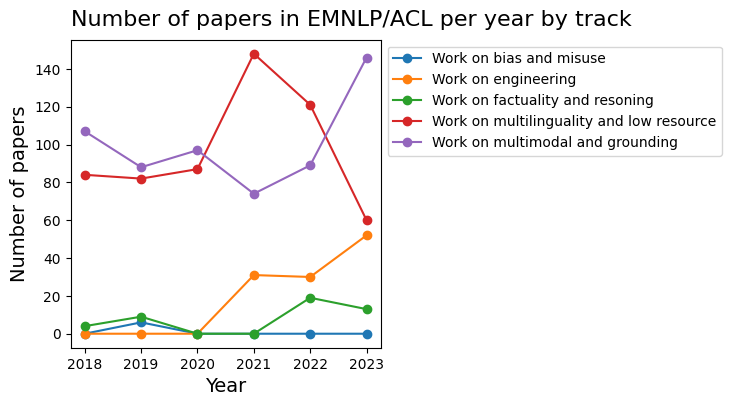

In [38]:
count_data = df.groupby('year')['survey_area'].value_counts().unstack().fillna(0)


tracks = count_data.columns
fig, ax = plt.subplots(figsize=(4, 4))
for track in tracks:
    ax.plot(count_data.index, count_data[track], marker='o',label=track)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of papers', fontsize=14)
plt.title('Number of papers in EMNLP/ACL per year by track', fontsize=16, pad=10, loc='left')
plt.tight_layout
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.show()
